In [1]:
import sys
sys.path.insert(0, sys.path[0].removesuffix('/src/crypto'))
print(sys.path)

['/home/marcelo/des/analise_ativos_mercado_financeiro', '/home/marcelo/des/analise_ativos_mercado_financeiro/src/crypto', '/usr/lib64/python310.zip', '/usr/lib64/python3.10', '/usr/lib64/python3.10/lib-dynload', '', '/home/marcelo/des/analise_ativos_mercado_financeiro/env/lib64/python3.10/site-packages', '/home/marcelo/des/analise_ativos_mercado_financeiro/env/lib/python3.10/site-packages', '/home/marcelo/des/analise_ativos_mercado_financeiro/env/lib/python3.10/site-packages/IPython/extensions', '/home/marcelo/.ipython']


In [2]:
import pandas as pd
from datetime import datetime
from pycaret.time_series import *
from pycaret import show_versions
import os
from src.calcEMA import calc_RSI

show_versions()


System:
    python: 3.10.12 (main, Jun  8 2023, 00:00:00) [GCC 13.1.1 20230511 (Red Hat 13.1.1-2)]
executable: /home/marcelo/des/analise_ativos_mercado_financeiro/env/bin/python
   machine: Linux-6.4.11-200.fc38.x86_64-x86_64-with-glibc2.37

PyCaret required dependencies:
                 pip: 23.2.1
          setuptools: 65.5.1
             pycaret: 3.0.4
             IPython: 7.34.0
          ipywidgets: 7.8.0
                tqdm: 4.66.1
               numpy: 1.23.5
              pandas: 1.5.3
              jinja2: 3.1.2
               scipy: 1.10.1
              joblib: 1.3.2
             sklearn: 1.2.2
                pyod: 1.1.0
            imblearn: 0.11.0
   category_encoders: 2.6.2
            lightgbm: 4.0.0
               numba: 0.57.1
            requests: 2.31.0
          matplotlib: 3.7.2
          scikitplot: 0.3.7
         yellowbrick: 1.5
              plotly: 5.16.1
    plotly-resampler: Not installed
             kaleido: 0.2.1
           schemdraw: 0.15
         st

In [3]:
# Variables
datadir = './data'
label = 'close'
use_cols = ['open_time', 'close']

### Metadata

<code>
Field Name - Description</br>
open_time - Kline Open time in unix time format</br>
open - Open Price</br>
high - High Price</br>
low	- Low Price</br>
close	- Close Price</br>
volume - Volume</br>
close_time - Kline Close time in unix time format</br>
quote_volume - Quote Asset Volume</br>
count	- Number of Trades</br>
taker_buy_volume - Taker buy base asset volume during this period</br>
taker_buy_quote_volume - Taker buy quote asset volume during this period</br>
ignore - Ignore</br>
</code>

In [4]:
def date_parser(x):
  return pd.to_datetime(x, unit='ms')

def read_data(dir, use_cols = ['open_time', 'close'] ):
  filenames = []

  for file in os.listdir(dir):
      if file.endswith(".csv"):
          filenames.append(os.path.join(dir, file))

  all_cols = ['open_time',	'open',	'high',	'low',	'close',	'volume', 'close_time', 'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore']   
  parse_dates = ['open_time']

  dataframes = []

  for filename in filenames:
    df = pd.read_csv(filename, names=all_cols, parse_dates=parse_dates, date_parser=date_parser, sep=',', decimal='.', usecols=use_cols)
    dataframes.append(df)

  # Concatenate all DataFrames into a single DataFrame
  combined_df = pd.concat(dataframes, ignore_index=True)
  combined_df.sort_values(['open_time'], inplace=True)
  combined_df['symbol'] = 'BTCUSDT'  
  combined_df.index = combined_df['open_time']
  combined_df.drop(columns=['open_time'], inplace=True)
  return combined_df

train_data = read_data(datadir, use_cols)
train_data = calc_RSI(train_data, label)
train_data.drop(columns=['symbol'], inplace=True)
train_data.dropna(inplace=True)
train_data = train_data.asfreq('H')
train_data['close'] = train_data['close'].ffill()
train_data['rsi'] = train_data['rsi'].ffill()
print(train_data.info())
print(train_data.shape)
train_data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21850 entries, 2021-01-01 14:00:00 to 2023-06-30 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   21850 non-null  float64
 1   rsi     21850 non-null  float64
dtypes: float64(2)
memory usage: 512.1 KB
None
(21850, 2)


,close,rsi
open_time,,
2021-01-01 14:00:00,29327.84,59.483943
2021-01-01 15:00:00,29188.67,54.801467
2021-01-01 16:00:00,29300.57,57.685711
2021-01-01 17:00:00,29079.64,50.793968
2021-01-01 18:00:00,29072.70,50.589506
...,...,...
2023-06-30 19:00:00,30372.36,46.052175
2023-06-30 20:00:00,30397.54,46.894044
2023-06-30 21:00:00,30479.56,49.650283


In [5]:
train_data.tail(20)

,close,rsi
open_time,,
2023-06-30 04:00:00,30877.99,69.539988
2023-06-30 05:00:00,30736.63,60.891784
2023-06-30 06:00:00,30665.99,57.072128
2023-06-30 07:00:00,30765.09,60.788245
2023-06-30 08:00:00,30854.00,63.814763
2023-06-30 09:00:00,30768.83,59.108285
2023-06-30 10:00:00,30811.52,60.673883
2023-06-30 11:00:00,30910.01,64.089842
2023-06-30 12:00:00,31010.11,67.207529


In [6]:
categorial_features = ['symbol']
#numeric_features = ['open',	'high',	'low','volume', 'close', 'rsi' ]
numeric_features = use_cols + ['rsi']
date_features = ['open_time']

exp_name = setup(data = train_data,
                 target = label,
                 fold = 3,
                 session_id = 123,
                 n_jobs = -1,
                 )

,Description,Value
0,session_id,123
1,Target,close
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(21850, 2)"
5,Transformed data shape,"(21850, 2)"
6,Transformed train set shape,"(21849, 2)"
7,Transformed test set shape,"(1, 2)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [7]:
#best = compare_models(sort = 'MAE') # 
best = 'huber_cds_dt' #'arima' # 'naive' 'auto_arima' 'rf_cds_dt' 'huber_cds_dt'

In [8]:
model = create_model(best)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2023-06-30 19:00,0.0161,0.0110,20.6487,20.6487,0.0007,0.0007
1,2023-06-30 20:00,0.0626,0.0426,80.2744,80.2744,0.0026,0.0026
2,2023-06-30 21:00,0.0332,0.0226,42.5963,42.5963,0.0014,0.0014
Mean,NaT,0.0373,0.0254,47.8398,47.8398,0.0016,0.0016
SD,NaT,0.0192,0.0131,24.6228,24.6228,0.0008,0.0008


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [9]:
prediction_holdout = predict_model(model, fh=720)
prediction_holdout.head(5)

,y_pred
2023-06-30 23:00,30489.3466
2023-07-01 00:00,30510.1753
2023-07-01 01:00,30499.6669
2023-07-01 02:00,30470.4247
2023-07-01 03:00,30471.5609


In [10]:
prediction_holdout.index = pd.DatetimeIndex(prediction_holdout.index.to_timestamp())

In [11]:
test_dir = './test'
test_data = read_data(test_dir, use_cols=use_cols)
test_data['original_label'] = test_data[label]
test_data = calc_RSI(test_data, label)
test_data.dropna(inplace=True)
#print(test_data.info())
test_data.head()

,close,symbol,original_label,rsi
open_time,,,,
2023-07-01 14:00:00,30608.52,BTCUSDT,30608.52,70.555803
2023-07-01 15:00:00,30572.58,BTCUSDT,30572.58,63.293998
2023-07-01 16:00:00,30572.00,BTCUSDT,30572.00,63.180984
2023-07-01 17:00:00,30573.86,BTCUSDT,30573.86,63.406637
2023-07-01 18:00:00,30608.87,BTCUSDT,30608.87,67.450350


In [12]:
test_data['prediction_label'] = prediction_holdout['y_pred']

In [13]:
import plotly.express as px

start_date = test_data.index.min().strftime("%Y-%m-%d")
end_date = test_data.index.max().strftime("%Y-%m-%d")
now = datetime.now().strftime("%Y-%m-%d")

filtered_date = test_data.loc[(test_data.index >= start_date) & (test_data.index <= end_date)]

fig1 = px.line(
    test_data, x=test_data.index, y=['original_label', 'prediction_label'], template = 'plotly_dark', 
    range_x=[start_date, end_date], title=f'Data: {end_date} \nPredição: {now}')
fig1.show()

<Axes: xlabel='open_time'>

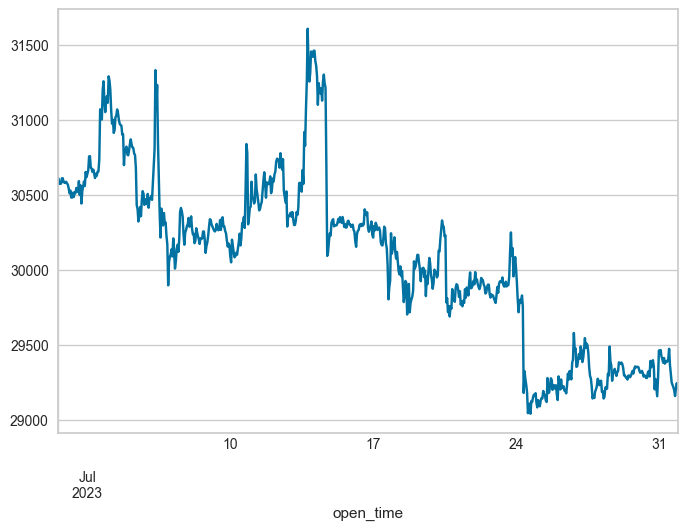

In [14]:
test_data['close'].plot()